# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('dark_background')

In [2]:
df = pd.read_csv('datasets/cleaned.csv', index_col=0)
df.head()

C:\Users\hunte\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,2015-12-01,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,-999.0,7.0,0.0,2765.0,29.7,13.0,Mar-2019,564.0,560.0,0.0,30.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,False
68355089,24700.0,36,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,2015-12-01,small_business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,-999.0,22.0,0.0,21470.0,19.2,38.0,Mar-2019,699.0,695.0,0.0,-999.0,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,113.0,192.0,2.0,2.0,4.0,2.0,-999.0,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,False
66310712,35000.0,60,14.85,829.90,C,C5,10,MORTGAGE,110000.0,Source Verified,2015-12-01,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,-999.0,-999.0,13.0,0.0,7802.0,11.6,17.0,Mar-2019,679.0,675.0,0.0,-999.0,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,36.0,87.0,2.0,2.0,1.0,2.0,-999.0,-999.0,-999.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,False
68476807,10400.0,60,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,2015-12-01,major_purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,-999.0,12.0,0.0,21929.0,64.5,35.0,Mar-2018,704.0,700.0,0.0,-999.0,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,False
68426831,11950.0,36,13.44,405.18,C,C3,4,RENT,34000.0,Source Verified,2015-12-01,debt_consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,-999.0,-999.0,5.0,0.0,8822.0,68.4,6.0,May-2017,759.0,755.0,0.0,-999.0,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,-999.0,-999.0,-999.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,False


# Default

We will start with our target feature. 

In [3]:
df['default'].value_counts(normalize=True)

False    0.857095
True     0.142905
Name: default, dtype: float64

It appears we are dealing with a very imbalanced dataset. That should be expected as a lender who has as many defaults as not will not be in business very long. Let's see if there are any big correlations.  

In [4]:
#changing default from boolean to 0s and 1s so we can correlate and for ML later. 
df['default'] = df['default']*1 
#correlating features with default 
corr = abs(df.corrwith(df['default'])).sort_values(ascending=False).round(2).head(20) 
corr

default                 1.00
last_fico_range_high    0.64
last_fico_range_low     0.59
int_rate                0.22
fico_range_low          0.12
fico_range_high         0.12
acc_open_past_24mths    0.11
num_tl_op_past_12m      0.10
open_rv_24m             0.09
dti                     0.09
term                    0.09
inq_last_6mths          0.09
inq_last_12m            0.08
open_acc_6m             0.08
bc_open_to_buy          0.08
open_rv_12m             0.07
open_il_12m             0.07
total_bc_limit          0.07
mths_since_rcnt_il      0.07
open_il_24m             0.07
dtype: float64

Looks like FICO scores correlate strongly which we would expect. The last fico range columns refer to the most recent credit pulls which are stronger than the normal fico range columns as those are pulls from back when the loan was originated. Interest rates are expected to correlate as they are also based on FICO score at the time of loan origination. Recent account openings would make sense as the more debts you take on, the tougher it should be to pay current debts. I would expect Debt-to-income ('dti') to play a bigger role as it's a caclulation of monthly debts to monthly income.  

# Creating Functions

This first function will group by the column that's been inputted and calculate the number of defaults. This will be used on columns that have obvious categorical groupings. 

In [5]:
def groupdef(col):
    return df.groupby(col).agg(total_defaults=('default', 'sum')) 

This next function will accept a column and a number of bins. It will group by those bins, calculate the number of defaults, and then create a new dataframe that will contain: the total number of loans, the % of the loans in this bin as part of the total, the total defaults, and the % of defaults that this grouping contains. 

In [6]:
def defaultsdf(col, bins):
    # Uses cut to create our bins for the dataframe.
    ranges = pd.cut(df[col], bins)  
    # Calculates the total loans in each category
    total_loans = ranges.value_counts().sort_index() 
    # Performs a groupby for our bins and calculates total defaults
    defaults = df.groupby(ranges).agg(total_defaults=('default', 'sum')) 
    # Combines total loans and total defaults into a single dataframe
    newdf = pd.concat([total_loans, defaults], axis=1) 
    # Renames our initial imputed column to total_loans
    newdf = newdf.rename(columns={col:'total_loans'}) 
    # Creates a new column that finds the % of our total that are in that bin
    newdf['%_of_loans'] = newdf['total_loans']/newdf['total_loans'].sum()*100 
    # Creates a new column that calculates the % of loans in that bin that defaulted
    newdf['%_that_defaulted'] = newdf['total_defaults']/newdf['total_loans']*100 
     # Reorders our columns so it reads better
    newdf = newdf[['total_loans','%_of_loans', 'total_defaults', '%_that_defaulted']]
    return newdf

# FICO Scores

There are 4 different features for FICO scores:
- last_fico_range_high: The upper boundary range the borrower’s last FICO pulled belongs to. 
- last_fico_range_low: The lower boundary range the borrower’s last FICO pulled belongs to.
- fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to.
- fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to.

In [7]:
#creating a new dateframe of just the fico columns and getting some quick summary statistics. 
df[['last_fico_range_high','last_fico_range_low','fico_range_high','fico_range_low']].agg(['min', 'mean', 'max'])

,last_fico_range_high,last_fico_range_low,fico_range_high,fico_range_low
min,0.000000,0.000000,664.000000,660.000000
mean,681.687321,667.683008,700.137496,696.137342
max,850.000000,845.000000,850.000000,845.000000


FICO scores range from 300-850 so a 0 score would technically be a no score. If the high was a 0, then it stands to reason the low would have to be a 0.

In [8]:
#Showing the value counts for 'last fico range low' everywhere that the 'last_fico_range_high' is 0.   
df[df['last_fico_range_high']==0]['last_fico_range_low'].value_counts()

0.0    43
Name: last_fico_range_low, dtype: int64

Makes sense. Let's see how the stats look with the low being 0.

In [9]:
df[df['last_fico_range_low']==0][['last_fico_range_high', 'fico_range_high', 'fico_range_low']].agg(['min','mean','max'])

,last_fico_range_high,fico_range_high,fico_range_low
min,0.000000,664.000000,660.000000
mean,498.141754,688.183873,684.183833
max,499.000000,850.000000,845.000000


In [10]:
df[df['last_fico_range_low']==0]['last_fico_range_high'].value_counts()

499.0    24958
0.0         43
Name: last_fico_range_high, dtype: int64

Since the 0 last_fico_highs only make up 43 rows of our million+ row dataset. I'm just going to toss them out. They're weird and won't mean much in the grand scheme of things.

In [11]:
df = df[df['last_fico_range_high'] > 0]

We're going to use our function to create a new dataframe.

In [12]:
#finding the max for our bins in the next step 
df['last_fico_range_high'].max() 

850.0

In [13]:
#creating our bins to create our groupings for the new dataframe
ficobins = [499, 550, 600, 650, 700, 750, 850] 
#using the function we created earlier to make the new dataframe.
lastficodf = defaultsdf('last_fico_range_high', ficobins) 
lastficodf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(499, 550]",78763,6.509925,60365,76.641316
"(550, 600]",101796,8.413650,57534,56.518920
"(600, 650]",128255,10.600542,26532,20.686913
"(650, 700]",346564,28.644233,7402,2.135825
"(700, 750]",357984,29.588120,1876,0.524046
"(750, 850]",196529,16.243529,603,0.306825


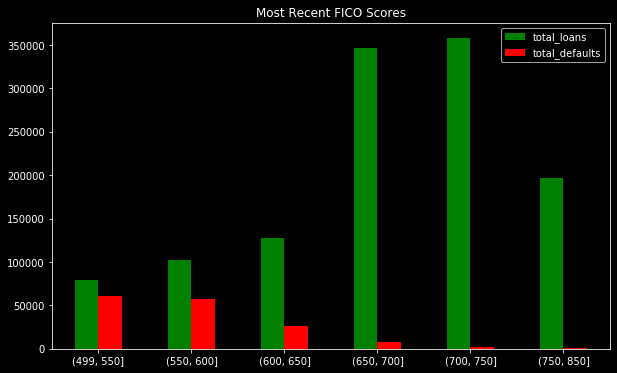

In [14]:
lastficodf[['total_loans','total_defaults']].plot(kind='bar', color=['green','red'], figsize=(10,6), rot=0, 
                                                  title='Most Recent FICO Scores')
plt.show()

Now let's compare that to our FICO scores from back when the loans were originated. 

In [15]:
#this will make .describe() easier to read 
pd.set_option('display.float_format', lambda x: '%.4f' % x) 
df['fico_range_high'].describe()

count   1234849.0000
mean        700.1373
std          31.8140
min         664.0000
25%         674.0000
50%         694.0000
75%         714.0000
max         850.0000
Name: fico_range_high, dtype: float64

In [16]:
newficobins = [664, 680, 700, 720, 740, 850]
ficodf = defaultsdf('fico_range_high', newficobins)
ficodf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(664, 680]",309656,27.6258,56609,18.2813
"(680, 700]",326458,29.1247,50181,15.3713
"(700, 720]",228131,20.3526,27284,11.9598
"(720, 740]",124785,11.1326,11554,9.2591
"(740, 850]",131866,11.7643,8299,6.2935


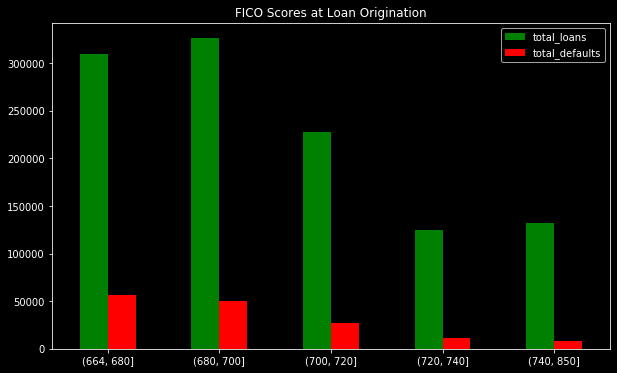

In [17]:
ficodf[['total_loans','total_defaults']].plot(kind='bar', color=['green','red'], figsize=(10,6), rot=0, 
                                              title='FICO Scores at Loan Origination')
plt.show()

# Grade

Lendingclub assigns a grade to each loan type so that investors have a good idea of the sort of risk that they're taking on. 

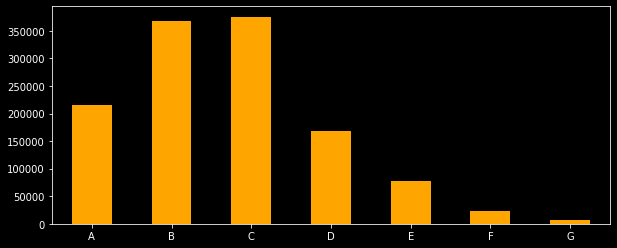

In [18]:
total_grades = df['grade'].value_counts().sort_index()
total_grades.plot(kind='bar', figsize=(10, 4), color='orange', rot=0)
plt.show()

The majority of lendingclubs loans are rated as above average. Let's see how many of these defaulted in each category. 

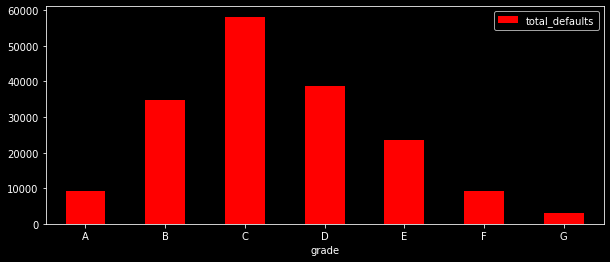

In [19]:
grade_defaults = groupdef('grade')
grade_defaults.plot(kind='bar', color='red', figsize=(10, 4), rot=0)
plt.show()

The most defaults were rated 'C' which is expected as it is the largest category and is the "middle of road" grade. Every letter after C appears to make up quite a disproportionate amount of defaults, especially when compared to A and B. 

In [20]:
#combines total grades and defaults into a single df
df_grades = pd.concat([total_grades, grade_defaults], axis=1).sort_index() 
#renames the grade column to total
df_grades = df_grades.rename({'grade':'total'}, axis=1) 
#creates a new column that calculates the % that default in each grade
df_grades['default_rate'] = df_grades['total_defaults']/df_grades['total']*100 
df_grades

,total,total_defaults,default_rate
grade,,,
A,214775,9135,4.2533
B,368025,34680,9.4233
C,375532,58200,15.4980
D,168188,38711,23.0165
E,76783,23444,30.5328
F,23990,9248,38.5494
G,7556,3044,40.2859


The worse the grade, the higher the default rate. LendingClub's grading criteria are doing a great job. 

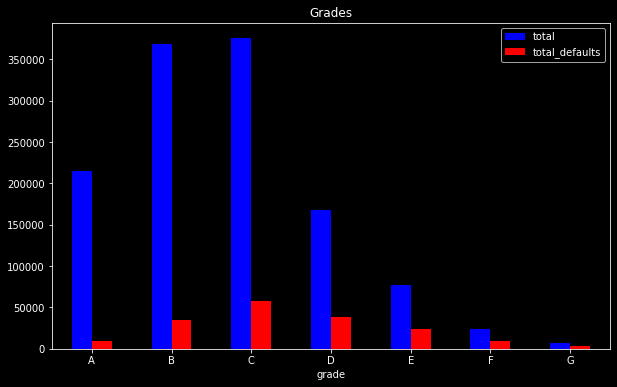

In [21]:
df_grades[['total','total_defaults']].plot(kind='bar', color=['blue','red'], figsize=(10,6), rot=0, title='Grades')
plt.show()

# Loan Amount

Our range of loan amounts:

In [22]:
df['loan_amnt'].agg(['min','max'])

min    1000.0000
max   40000.0000
Name: loan_amnt, dtype: float64

In [23]:
loanbins = [0,5000,10000,15000,20000,25000,30000,35000,40000]
amntdf = defaultsdf('loan_amnt', loanbins)
amntdf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(0, 5000]",168268,13.6266,19147,11.3789
"(5000, 10000]",327642,26.5330,42374,12.9330
"(10000, 15000]",257647,20.8647,38906,15.1005
"(15000, 20000]",196763,15.9342,31560,16.0396
"(20000, 25000]",124642,10.0937,19732,15.8309
"(25000, 30000]",75062,6.0786,11449,15.2527
"(30000, 35000]",69760,5.6493,12081,17.3179
"(35000, 40000]",15065,1.2200,1213,8.0518


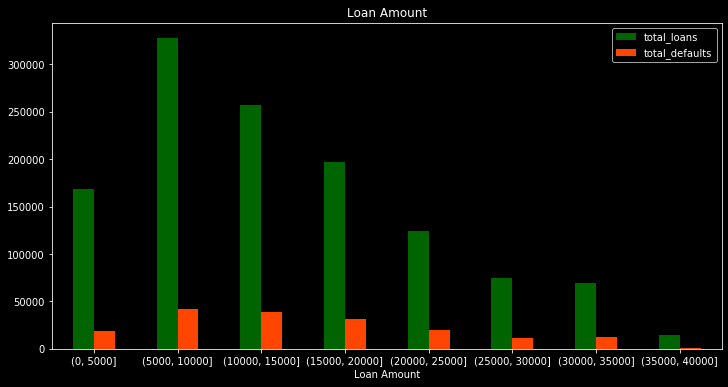

In [24]:
amntdf[['total_loans','total_defaults']].plot(kind='bar', figsize=(12,6), color=['darkgreen','orangered'], rot=0, 
                                             title='Loan Amount')
plt.xlabel('Loan Amount')
plt.show()


# Debt-To-Income

Let's see our ranges for Debt-to-income or DTI. 

In [25]:
df['dti'].agg(['min','max'])

min   -1.0000
max   49.9600
Name: dti, dtype: float64

In [26]:
df[df['dti'] <= 0]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67605866,4000.0000,36,10.7800,130.5400,B,B4,2,OWN,36000.0000,Source Verified,2015-12-01,car,062xx,CT,0.0000,0.0000,Aug-2012,730.0000,734.0000,0.0000,-999.0000,-999.0000,5.0000,0.0000,0.0000,0.0000,5.0000,Feb-2019,669.0000,665.0000,0.0000,-999.0000,0.0000,0.0000,6976.0000,1.0000,0.0000,0.0000,0.0000,-999.0000,0.0000,nan,0.0000,1.0000,0.0000,0.0000,11200.0000,1.0000,0.0000,3.0000,2.0000,1395.0000,5500.0000,0.0000,0.0000,130.0000,40.0000,16.0000,4.0000,1.0000,27.0000,-999.0000,0.0000,-999.0000,0.0000,0.0000,0.0000,2.0000,2.0000,0.0000,4.0000,4.0000,0.0000,5.0000,0.0000,0.0000,0.0000,1.0000,100.0000,0.0000,0.0000,0.0000,18200.0000,0.0000,5500.0000,0.0000,0
68503950,12000.0000,60,18.4900,307.9300,D,D5,6,OWN,48000.0000,Not Verified,2015-12-01,home_improvement,320xx,FL,0.0000,0.0000,Feb-1983,780.0000,784.0000,0.0000,-999.0000,-999.0000,1.0000,0.0000,0.0000,0.0000,7.0000,Mar-2019,794.0000,790.0000,0.0000,-999.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,30.0000,0.0000,nan,0.0000,0.0000,0.0000,0.0000,8000.0000,0.0000,0.0000,1.0000,0.0000,0.0000,8000.0000,0.0000,0.0000,159.0000,394.0000,42.0000,30.0000,0.0000,110.0000,-999.0000,1.0000,-999.0000,0.0000,0.0000,0.0000,1.0000,3.0000,3.0000,1.0000,4.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,8000.0000,0.0000,8000.0000,0.0000,0
68353718,5000.0000,36,8.4900,157.8200,B,B1,4,MORTGAGE,50000.0000,Not Verified,2015-12-01,major_purchase,301xx,GA,0.0000,0.0000,Apr-2011,765.0000,769.0000,0.0000,-999.0000,-999.0000,2.0000,0.0000,0.0000,0.0000,4.0000,Aug-2018,734.0000,730.0000,0.0000,-999.0000,0.0000,0.0000,101389.0000,0.0000,0.0000,0.0000,0.0000,-999.0000,0.0000,nan,0.0000,0.0000,0.0000,0.0000,3200.0000,0.0000,0.0000,0.0000,1.0000,50695.0000,3200.0000,0.0000,0.0000,130.0000,56.0000,31.0000,18.0000,1.0000,31.0000,-999.0000,18.0000,-999.0000,0.0000,0.0000,0.0000,1.0000,3.0000,0.0000,1.0000,3.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,100.0000,0.0000,0.0000,0.0000,107700.0000,0.0000,3200.0000,0.0000,0
66542505,4000.0000,36,11.9900,132.8400,C,C1,3,RENT,94000.0000,Verified,2015-12-01,other,117xx,NY,0.0000,2.0000,Sep-1993,705.0000,709.0000,1.0000,21.0000,69.0000,7.0000,1.0000,0.0000,0.0000,14.0000,Dec-2018,499.0000,0.0000,0.0000,21.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,142.0000,0.0000,nan,3.0000,5.0000,0.0000,0.0000,15600.0000,0.0000,0.0000,1.0000,5.0000,0.0000,12500.0000,0.0000,0.0000,142.0000,267.0000,1.0000,1.0000,1.0000,1.0000,22.0000,1.0000,21.0000,0.0000,0.0000,0.0000,3.0000,6.0000,1.0000,7.0000,12.0000,0.0000,7.0000,0.0000,0.0000,1.0000,3.0000,76.9000,0.0000,0.0000,1.0000,15600.0000,0.0000,12500.00

Negative Debt to Income isn't possible so I will remove that value. I am also suspicious of the 0 DTI figures but they are certainly possible when you omit housing payments and the Lendingclub loan itself as LC does in its data. 

In [27]:
df = df[df['dti'] >= 0]

In [28]:
df['dti'].agg(['min','max'])

min    0.0000
max   49.9600
Name: dti, dtype: float64

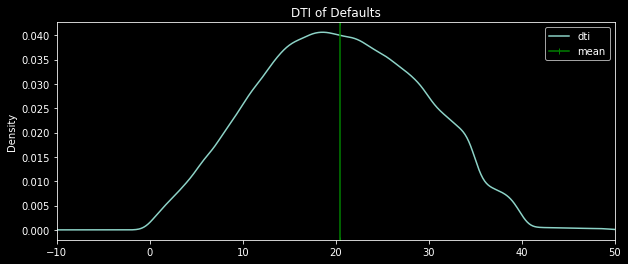

In [29]:
df[df['default']==1]['dti'].plot(kind='kde', figsize=(10,4), xlim=(-10,50), title='DTI of Defaults')
plt.axvline(df[df['default']==1]['dti'].mean(), color='green', marker='|', label='mean')
plt.legend()
plt.show()

This Kernel Density Estimate of the DTIs is very close to Gaussian. Looks like the average DTI of a default is just above 20.

In [30]:
df['dti'].describe()

count   1234848.0000
mean         18.5801
std           8.4907
min           0.0000
25%          12.2000
50%          18.0900
75%          24.6600
max          49.9600
Name: dti, dtype: float64

In [31]:
dtibins = [0,5,10,15,20,25,30,50]
dtidf = defaultsdf('dti',dtibins)
dtidf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(0, 5]",55236,4.4746,5904,10.6887
"(5, 10]",154137,12.4863,16536,10.7281
"(10, 15]",243629,19.7359,28647,11.7585
"(15, 20]",262644,21.2762,35239,13.4170
"(20, 25]",223696,18.1211,34086,15.2376
"(25, 30]",164727,13.3442,28691,17.4173
"(30, 50]",130379,10.5617,27311,20.9474


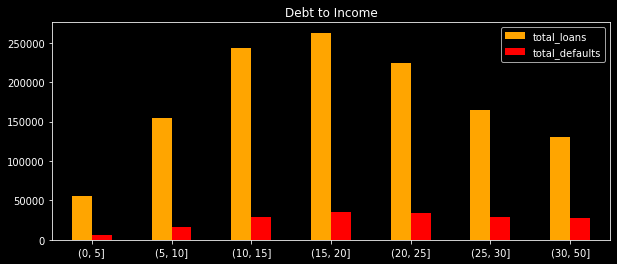

In [32]:
dtidf[['total_loans', 'total_defaults']].plot(kind='bar', figsize=(10,4), color=['orange', 'red'], rot=0, 
                                              title= 'Debt to Income')
plt.show()

# Annual Income

Let's see the ranges of our annual incomes. 

In [33]:
df['annual_inc'].agg(['min','max'])

min        2000.0000
max   110000000.0000
Name: annual_inc, dtype: float64

Apparently we have a client in our dataset who makes  110 million a year. While not impossible, it would seem unlikely that someone like that would be wanting a $40,000 loan considering they make over 7 times that amount every day of the year. Let's see if we have any other outrageous income amounts.  

In [34]:
df.nlargest(10, 'annual_inc')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
113245115,30000.0000,60,9.9300,636.3800,B,B2,10,RENT,110000000.0000,Verified,2017-08-01,debt_consolidation,073xx,NJ,0.0100,0.0000,Apr-1994,695.0000,699.0000,0.0000,-999.0000,-999.0000,5.0000,0.0000,20298.0000,83.5000,13.0000,Mar-2019,694.0000,690.0000,0.0000,-999.0000,0.0000,0.0000,20298.0000,0.0000,0.0000,0.0000,0.0000,108.0000,0.0000,nan,1.0000,1.0000,11791.0000,84.0000,24300.0000,0.0000,0.0000,1.0000,1.0000,4060.0000,2143.0000,89.9000,0.0000,108.0000,279.0000,9.0000,9.0000,0.0000,103.0000,-999.0000,9.0000,-999.0000,0.0000,3.0000,5.0000,3.0000,7.0000,1.0000,5.0000,12.0000,5.0000,5.0000,0.0000,0.0000,0.0000,1.0000,100.0000,100.0000,0.0000,0.0000,24300.0000,20298.0000,21300.0000,0.0000,0
101074293,10000.0000,36,11.4400,329.4800,B,B4,10,MORTGAGE,61000000.0000,Source Verified,2017-03-01,debt_consolidation,234xx,VA,0.0100,0.0000,Apr-1996,690.0000,694.0000,1.0000,44.0000,-999.0000,3.0000,0.0000,14413.0000,35.1000,6.0000,Mar-2019,669.0000,665.0000,0.0000,-999.0000,0.0000,0.0000,14413.0000,0.0000,0.0000,0.0000,0.0000,-999.0000,0.0000,nan,0.0000,0.0000,4571.0000,35.0000,41100.0000,0.0000,0.0000,3.0000,0.0000,4804.0000,24420.0000,23.2000,0.0000,130.0000,251.0000,140.0000,140.0000,0.0000,192.0000,44.0000,3.0000,44.0000,0.0000,2.0000,3.0000,2.0000,4.0000,0.0000,3.0000,6.0000,3.0000,3.0000,0.0000,0.0000,0.0000,0.0000,66.7000,0.0000,0.0000,0.0000,41100.0000,14413.0000,31800.0000,0.0000,0
118198788,5000.0000,36,18.0600,180.9200,D,D2,1,RENT,10999200.0000,Source Verified,2017-09-01,major_purchase,913xx,CA,0.0700,1.0000,Jan-1998,685.0000,689.0000,0.0000,13.0000,-999.0000,4.0000,0.0000,534.0000,41.1000,7.0000,Jan-2019,684.0000,680.0000,0.0000,28.0000,0.0000,0.0000,7704.0000,0.0000,2.0000,0.0000,0.0000,30.0000,7170.0000,25.0000,0.0000,0.0000,0.0000,26.0000,1300.0000,1.0000,0.0000,0.0000,0.0000,1926.0000,700.0000,0.0000,0.0000,60.0000,236.0000,165.0000,30.0000,0.0000,184.0000,28.0000,13.0000,28.0000,1.0000,0.0000,1.0000,1.0000,2.0000,2.0000,2.0000,4.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,57.1000,0.0000,0.0000,0.0000,29969.0000,7704.0000,700.0000,28669.0000,0
76323387,30000.0000,36,7.3900,931.6800,A,A4,7,OWN,9573072.0000,Source Verified,2016-04-01,debt_consolidation,926xx,CA,0.1600,1.0000,May-2003,680.0000,684.0000,0.0000,18.0000,-999.0000,11.0000,0.0000,31391.0000,61.9000,35.0000,Mar-2019,539.0000,535.0000,0.0000,-999.0000,0.0000,0.0000,558335.0000,1.0000,3.0000,0.0000,2.0000,16.0000,36157.0000,81.0000,0.0000,0.0000,11548.0000,71.0000,50700.0000,8.0000,9.0000,10.0000,3.0000,50758.0000,9662.0000,68.2000,0.0000,155.0000,143.0000,30.0000,4.0000,1.0000,44.0000,-999.0000,2.0000,18.0000,0.0000,3.0000,6

Gotta love the fact that we've supposedly got a client who makes 11 million a year but wants a 5000 loan and its rated D. I'm just going to get rid of all these outrageously high incomes as I think we can reasonably guess that they are inaccurate.  

In [35]:
df = df[df['annual_inc'] < 600_000]

In [36]:
df.nlargest(10, 'annual_inc')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
119231153,35000.0000,60,18.0600,889.9200,D,D2,10,MORTGAGE,598000.0000,Verified,2017-09-01,home_improvement,271xx,NC,3.5600,0.0000,Feb-1991,665.0000,669.0000,0.0000,65.0000,-999.0000,6.0000,0.0000,7062.0000,63.6000,11.0000,Mar-2019,704.0000,700.0000,0.0000,65.0000,0.0000,0.0000,530629.0000,1.0000,1.0000,1.0000,1.0000,5.0000,14026.0000,97.0000,0.0000,0.0000,5571.0000,82.0000,11100.0000,0.0000,0.0000,0.0000,1.0000,88438.0000,638.0000,91.7000,0.0000,144.0000,319.0000,32.0000,5.0000,2.0000,205.0000,-999.0000,-999.0000,81.0000,2.0000,2.0000,2.0000,2.0000,3.0000,3.0000,3.0000,5.0000,2.0000,6.0000,0.0000,0.0000,0.0000,1.0000,45.5000,50.0000,0.0000,0.0000,607163.0000,61659.0000,7700.0000,14500.0000,0
119049197,35000.0000,60,9.4400,734.0400,B,B1,6,MORTGAGE,597000.0000,Source Verified,2017-09-01,moving,079xx,NJ,14.0400,0.0000,Jan-1993,770.0000,774.0000,1.0000,-999.0000,-999.0000,19.0000,0.0000,280030.0000,26.5000,30.0000,Mar-2019,689.0000,685.0000,0.0000,-999.0000,0.0000,0.0000,894866.0000,2.0000,2.0000,1.0000,2.0000,5.0000,105809.0000,87.0000,1.0000,2.0000,14228.0000,36.0000,410000.0000,1.0000,0.0000,6.0000,4.0000,47098.0000,109024.0000,28.0000,0.0000,296.0000,211.0000,5.0000,5.0000,1.0000,5.0000,-999.0000,3.0000,-999.0000,0.0000,6.0000,7.0000,11.0000,12.0000,8.0000,15.0000,20.0000,7.0000,19.0000,0.0000,0.0000,0.0000,2.0000,100.0000,0.0000,0.0000,0.0000,1206917.0000,427430.0000,151400.0000,130030.0000,0
114166268,35000.0000,36,21.4500,1326.7300,D,D5,1,RENT,597000.0000,Source Verified,2017-07-01,other,100xx,NY,0.9500,0.0000,Oct-1995,665.0000,669.0000,0.0000,-999.0000,-999.0000,6.0000,0.0000,17065.0000,44.6000,16.0000,Feb-2019,744.0000,740.0000,0.0000,-999.0000,0.0000,264.0000,17065.0000,0.0000,0.0000,3.0000,3.0000,8.0000,0.0000,nan,2.0000,3.0000,8885.0000,45.0000,38300.0000,0.0000,0.0000,1.0000,6.0000,4266.0000,17831.0000,42.1000,0.0000,142.0000,261.0000,7.0000,7.0000,1.0000,9.0000,-999.0000,12.0000,-999.0000,0.0000,2.0000,3.0000,3.0000,5.0000,5.0000,6.0000,9.0000,3.0000,6.0000,0.0000,0.0000,0.0000,5.0000,100.0000,0.0000,0.0000,0.0000,38300.0000,17065.0000,30800.0000,0.0000,0
44796014,25975.0000,36,9.1700,828.0600,B,B2,6,OWN,596818.0000,Verified,2015-04-01,home_improvement,112xx,NY,20.5700,1.0000,Mar-2001,720.0000,724.0000,3.0000,8.0000,29.0000,9.0000,1.0000,43500.0000,17.9000,18.0000,Jul-2018,584.0000,580.0000,0.0000,45.0000,0.0000,0.0000,1466963.0000,nan,nan,nan,nan,-999.0000,nan,nan,nan,nan,nan,nan,90800.0000,nan,nan,nan,1.0000,183370.0000,47300.0000,17.9000,0.0000,60.0000,168.0000,25.0000,14.0000,3.0000,25.0000,-999.0000,0.0000,8.0000,1.0000,5.0000,5.0000,6.0000,10.0000,2.0000,6.0000,12.0000,

That seems more reasonable. Let's get a look at these incomes now. 

In [37]:
df['annual_inc'].describe()

count   1233384.0000
mean      78467.8530
std       49308.0936
min        2000.0000
25%       48000.0000
50%       67000.0000
75%       95000.0000
max      598000.0000
Name: annual_inc, dtype: float64

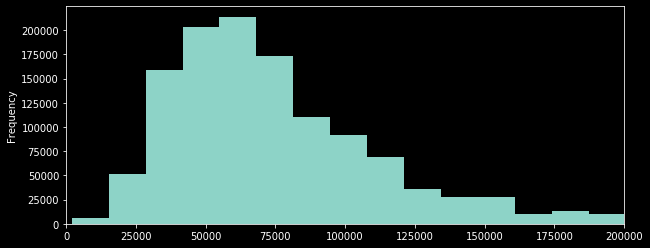

In [38]:
df['annual_inc'].plot(kind='hist', bins=45, figsize=(10,4), xlim=(0,200_000))
plt.show()

I realize I am omitting some the borrowers (potential outliers) who allegedly make more than 200,000 but it looks like 95%+ of my data is represented in this histogram. 

In [39]:
incbins = [0, 35_000, 45_000, 55_000, 65_000, 75_000, 85_000, 100_000, 125_000, 600_000]
incomedf = defaultsdf('annual_inc', incbins)
incomedf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(0, 35000]",133111,10.7923,23573,17.7093
"(35000, 45000]",148370,12.0295,24469,16.4919
"(45000, 55000]",165748,13.4385,25911,15.6328
"(55000, 65000]",160396,13.0045,24214,15.0964
"(65000, 75000]",134584,10.9118,19155,14.2327
"(75000, 85000]",108137,8.7675,14874,13.7548
"(85000, 100000]",127140,10.3082,16354,12.8630
"(100000, 125000]",116564,9.4507,13622,11.6863
"(125000, 600000]",139334,11.2969,14188,10.1827


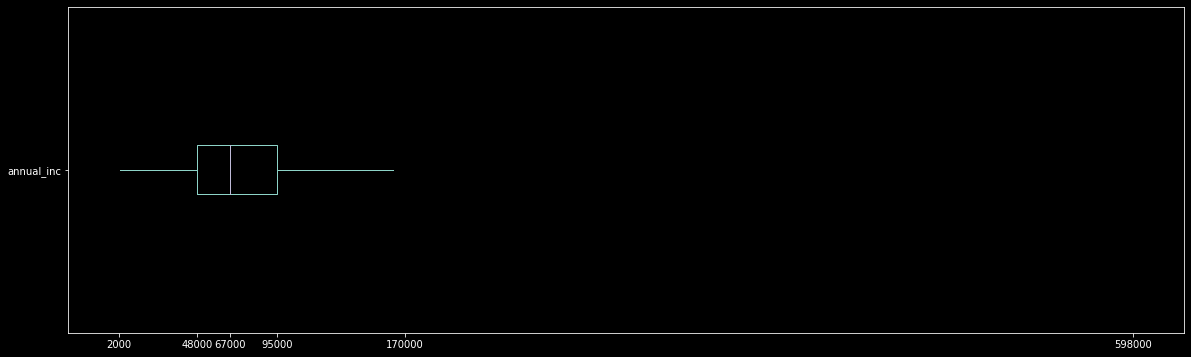

In [40]:
df['annual_inc'].plot(kind='box', vert=False, figsize=(20, 6));
plt.xticks([2000, 48000, 95000, df['annual_inc'].median(), 170000, 598000])
plt.show()

Looks like any income over around 170000 is a potential outlier.

# Interest Rates

In [41]:
df['int_rate'].describe()

count   1233384.0000
mean         12.9139
std           4.8167
min           5.3200
25%           9.4400
50%          12.2900
75%          15.5900
max          30.9900
Name: int_rate, dtype: float64

These rates are within acceptable lendingclub parameters so we should be good to go. Let's create a new dataframe sorting our interest rates into categories and look at the number of defaults. 

There's a marked increase in default rate as you go up in interest rate. They make up quite a disproportionate number of our defaults. 

In [42]:
intratebins=[5,10,15,20,25,31]
intdf = defaultsdf('int_rate', intratebins)
intdf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(5, 10]",378594,30.6955,22999,6.0748
"(10, 15]",515799,41.8198,70160,13.6022
"(15, 20]",252462,20.4691,56258,22.2837
"(20, 25]",57320,4.6474,17183,29.9773
"(25, 31]",29209,2.3682,9760,33.4144


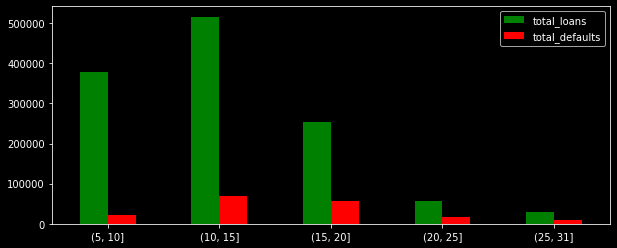

In [43]:
intdf[['total_loans', 'total_defaults']].plot(kind='bar', figsize=(10,4), color=['green','red'], rot=0)
plt.show()

# Employment Length

Employment length ranges from less than 1 year (0) to 10 years or more (10). They are distributed like so:

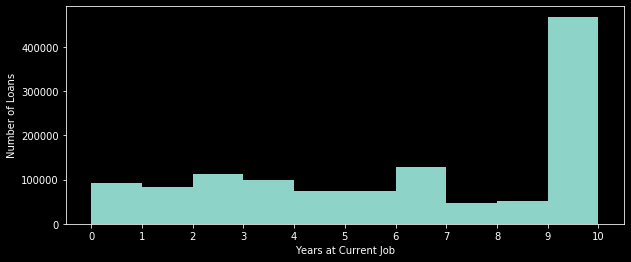

In [44]:
df['emp_length'].plot(kind='hist', xticks=range(0,11), figsize=(10,4))
plt.ylabel('Number of Loans')
plt.xlabel('Years at Current Job')
plt.show()

Vast majority are 10+. That kind of stability is usually valued highly in the lending game. Time to see what the defaults look like. 

In [45]:
emp_defaults = groupdef('emp_length')

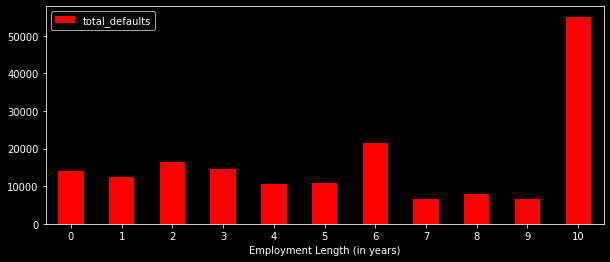

In [46]:
emp_defaults.plot(kind='bar', color='red', figsize=(10, 4))
plt.xlabel('Employment Length (in years)')
plt.xticks(rotation=0)
plt.show()

Most defaults are 10+ but that's expected since the data is comprised of so many 10+ year employees. Adjusting for the number of loans should tell a different story. 

In [47]:
emp_defaults['total_loans'] = df['emp_length'].value_counts()

In [48]:
emp_defaults['%_default'] = emp_defaults['total_defaults']/emp_defaults['total_loans']*100

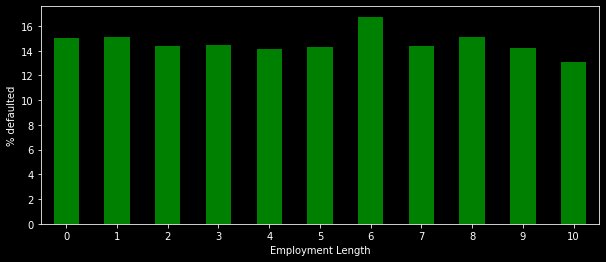

In [49]:
emp_defaults['%_default'].plot(kind='bar', figsize=(10,4), color='green')
plt.ylabel('% defaulted')
plt.xlabel('Employment Length')
plt.xticks(rotation=0)
plt.show()

There is minimal difference in how employment length affects loan default rate.

# Term

In [50]:
termdef = groupdef('term')
termdef['total_loans'] = df['term'].value_counts()
termdef['%_of_total'] = termdef['total_loans']/len(df)
termdef['%_default'] = termdef['total_defaults']/termdef['total_loans']*100
termdef['%_of_tot_defaults'] = termdef['total_defaults']/termdef['total_defaults'].sum()
termdef

,total_defaults,total_loans,%_of_total,%_default,%_of_tot_defaults
term,,,,,
36,110069,886768,0.7190,12.4124,0.6241
60,66291,346616,0.2810,19.1252,0.3759


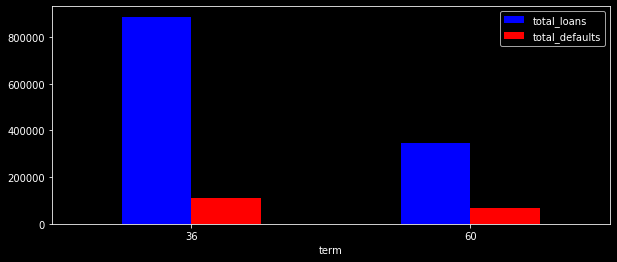

In [51]:
termdef[['total_loans', 'total_defaults']].plot(kind='bar', color=['blue','red'], figsize=(10,4), rot=0)
plt.show()

# Number of Trades Opened

In [52]:
df['acc_open_past_24mths'].describe()

count   1233384.0000
mean          4.6920
std           3.2525
min           0.0000
25%           2.0000
50%           4.0000
75%           6.0000
max          64.0000
Name: acc_open_past_24mths, dtype: float64

In [53]:
tradesbins = [0,1,2,3,4,5,6,8,65]
loansdf = defaultsdf('acc_open_past_24mths', tradesbins)
loansdf

,total_loans,%_of_loans,total_defaults,%_that_defaulted
"(0, 1]",116308,9.8378,10802,9.2874
"(1, 2]",162876,13.7767,17071,10.4810
"(2, 3]",179689,15.1988,21509,11.9701
"(3, 4]",169995,14.3789,23146,13.6157
"(4, 5]",145617,12.3169,21763,14.9454
"(5, 6]",115654,9.7825,19091,16.5070
"(6, 8]",151248,12.7932,27746,18.3447
"(8, 65]",140868,11.9152,30892,21.9297


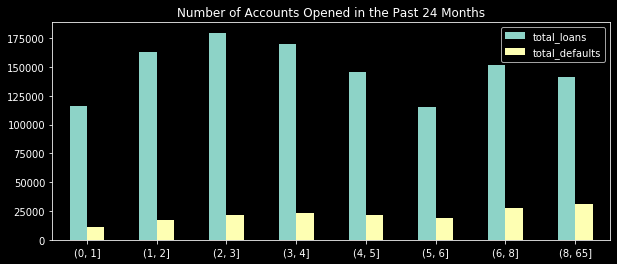

In [54]:
loansdf[['total_loans', 'total_defaults']].plot(kind='bar', figsize=(10,4), rot=0, 
                                                title='Number of Accounts Opened in the Past 24 Months')
plt.show()

# Issue Date

In [55]:
issue = df[['issue_d', 'default']]
issue['issue_d'] = pd.to_datetime(issue['issue_d'])

C:\Users\hunte\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


      default  total_loans  default_rate
2015    74897       416320       17.9902
2016    66241       420833       15.7404
2017    35222       396231        8.8893


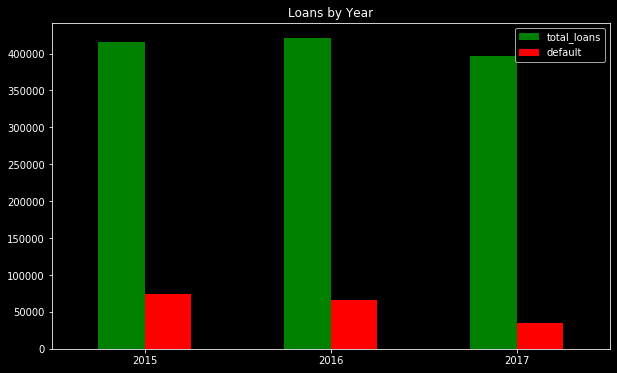

In [56]:
years = issue.set_index('issue_d').groupby(pd.Grouper(freq='Y')).agg('sum')
years['total_loans'] = issue.groupby([pd.Grouper(key='issue_d',freq='Y')]).size()
years['default_rate'] = years['default']/years['total_loans']*100
years.index = ['2015', '2016', '2017']
years[['total_loans', 'default']].plot(kind='bar', color=['green', 'red'], rot=0, figsize=(10,6), title='Loans by Year')
print(years)
plt.show()

The loan default rate cuts in half between 2015 and 2017. This is rather intuitive though. The 2017 loans are so new that they have not had time to default as much yet. Would we slowly see the default rate go down over time if we stretched it out to quarters?

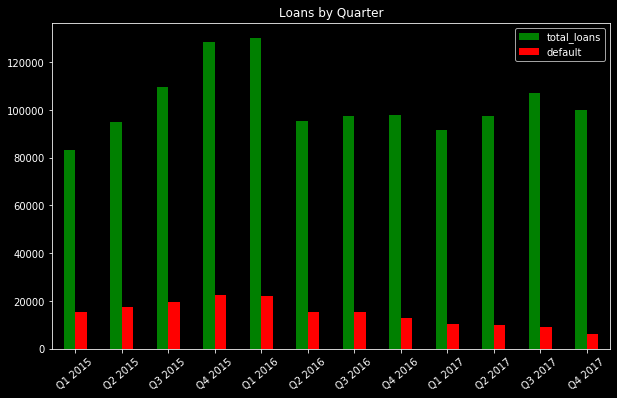

In [57]:
quarters = issue.set_index('issue_d').groupby(pd.Grouper(freq='Q')).agg('sum')
quarters['total_loans'] = issue.groupby([pd.Grouper(key='issue_d',freq='Q')]).size()
quarters['default_rate'] = quarters['default']/quarters['total_loans']*100
quarters.index = ['Q1 2015', 'Q2 2015', 'Q3 2015', 'Q4 2015', 'Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016',
                 'Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017']
quarters[['total_loans', 'default']].plot(kind='bar', color=['green', 'red'], rot=40, figsize=(10,6), 
                                          title='Loans by Quarter')
plt.show()

In [58]:
quarters

,default,total_loans,default_rate
Q1 2015,15245,83391,18.2813
Q2 2015,17509,94879,18.4540
Q3 2015,19621,109420,17.9318
Q4 2015,22522,128630,17.5091
Q1 2016,22140,130063,17.0225
Q2 2016,15509,95272,16.2787
Q3 2016,15565,97429,15.9757
Q4 2016,13027,98069,13.2835
Q1 2017,10219,91397,11.1809
Q2 2017,9837,97592,10.0797


Interesting that the number of defaults slowly goes up from Q1-15 to Q4-15 but then starts decreasing from there. 

I'll be tossing out issue date before we do machine learning since time series machine learning is beyond our scope. However, since the loan id numbers are sequential, the model should discover that the higher the ID number, the lower the chance of default.

# Finalizing the Dataset

In [59]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0000,36,13.9900,123.0300,C,C4,10,MORTGAGE,55000.0000,Not Verified,2015-12-01,debt_consolidation,190xx,PA,5.9100,0.0000,Aug-2003,675.0000,679.0000,1.0000,30.0000,-999.0000,7.0000,0.0000,2765.0000,29.7000,13.0000,Mar-2019,564.0000,560.0000,0.0000,30.0000,0.0000,722.0000,144904.0000,2.0000,2.0000,0.0000,1.0000,21.0000,4981.0000,36.0000,3.0000,3.0000,722.0000,34.0000,9300.0000,3.0000,1.0000,4.0000,4.0000,20701.0000,1506.0000,37.2000,0.0000,148.0000,128.0000,3.0000,3.0000,1.0000,4.0000,69.0000,4.0000,69.0000,2.0000,2.0000,4.0000,2.0000,5.0000,3.0000,4.0000,9.0000,4.0000,7.0000,0.0000,0.0000,0.0000,3.0000,76.9000,0.0000,0.0000,0.0000,178050.0000,7746.0000,2400.0000,13734.0000,0
68355089,24700.0000,36,11.9900,820.2800,C,C1,10,MORTGAGE,65000.0000,Not Verified,2015-12-01,small_business,577xx,SD,16.0600,1.0000,Dec-1999,715.0000,719.0000,4.0000,6.0000,-999.0000,22.0000,0.0000,21470.0000,19.2000,38.0000,Mar-2019,699.0000,695.0000,0.0000,-999.0000,0.0000,0.0000,204396.0000,1.0000,1.0000,0.0000,1.0000,19.0000,18005.0000,73.0000,2.0000,3.0000,6472.0000,29.0000,111800.0000,0.0000,0.0000,6.0000,4.0000,9733.0000,57830.0000,27.1000,0.0000,113.0000,192.0000,2.0000,2.0000,4.0000,2.0000,-999.0000,0.0000,6.0000,0.0000,5.0000,5.0000,13.0000,17.0000,6.0000,20.0000,27.0000,5.0000,22.0000,0.0000,0.0000,0.0000,2.0000,97.4000,7.7000,0.0000,0.0000,314017.0000,39475.0000,79300.0000,24667.0000,0
66310712,35000.0000,60,14.8500,829.9000,C,C5,10,MORTGAGE,110000.0000,Source Verified,2015-12-01,debt_consolidation,076xx,NJ,17.0600,0.0000,Sep-2008,785.0000,789.0000,0.0000,-999.0000,-999.0000,13.0000,0.0000,7802.0000,11.6000,17.0000,Mar-2019,679.0000,675.0000,0.0000,-999.0000,0.0000,0.0000,301500.0000,1.0000,1.0000,0.0000,1.0000,23.0000,12609.0000,70.0000,1.0000,1.0000,6987.0000,45.0000,67300.0000,0.0000,1.0000,0.0000,2.0000,23192.0000,54962.0000,12.1000,0.0000,36.0000,87.0000,2.0000,2.0000,1.0000,2.0000,-999.0000,-999.0000,-999.0000,0.0000,4.0000,5.0000,8.0000,10.0000,2.0000,10.0000,13.0000,5.0000,13.0000,0.0000,0.0000,0.0000,1.0000,100.0000,0.0000,0.0000,0.0000,381215.0000,52226.0000,62500.0000,18000.0000,0
68476807,10400.0000,60,22.4500,289.9100,F,F1,3,MORTGAGE,104433.0000,Source Verified,2015-12-01,major_purchase,174xx,PA,25.3700,1.0000,Jun-1998,695.0000,699.0000,3.0000,12.0000,-999.0000,12.0000,0.0000,21929.0000,64.5000,35.0000,Mar-2018,704.0000,700.0000,0.0000,-999.0000,0.0000,0.0000,331730.0000,1.0000,3.0000,0.0000,3.0000,14.0000,73839.0000,84.0000,4.0000,7.0000,9702.0000,78.0000,34000.0000,2.0000,1.0000,3.0000,10.0000,27644.0000,4567.0000,77.5000,0.0000,128.0000,210.0000,4.0000,4.0000,6.0000,4.0000,12.0

# Finalizing for Machine Learning

Last thing to do before we start Machine Learning is we need to ensure that we don't have any strings in our columns and that we have no missing values.

In [60]:
types = df.dtypes
types = types[types=='object']
types

grade                  object
sub_grade              object
home_ownership         object
verification_status    object
issue_d                object
purpose                object
zip_code               object
addr_state             object
earliest_cr_line       object
last_credit_pull_d     object
dtype: object

Some of these strings are potentially useful for our model. I am going to select a subset of these and use onehotencoding to keep them in my data for Machine Learning. 

In [61]:
onehotlist = ['grade','home_ownership','verification_status','home_ownership', 'purpose']

In [62]:
from sklearn.preprocessing import OneHotEncoder

In [63]:
onehotdf = df[onehotlist]
onehotdf.head()

,grade,home_ownership,verification_status,home_ownership,purpose
id,,,,,
68407277,C,MORTGAGE,Not Verified,MORTGAGE,debt_consolidation
68355089,C,MORTGAGE,Not Verified,MORTGAGE,small_business
66310712,C,MORTGAGE,Source Verified,MORTGAGE,debt_consolidation
68476807,F,MORTGAGE,Source Verified,MORTGAGE,major_purchase
68426831,C,RENT,Source Verified,RENT,debt_consolidation


In [64]:
#initializaing the one hot encoder and dropping the first column of each to reduce multicollinearity. 
hot = OneHotEncoder(drop='first',sparse=False)

In [65]:
encoded = hot.fit_transform(onehotdf)

In [66]:
encdf = pd.DataFrame(encoded, columns=hot.get_feature_names())
encdf.head()

,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_MORTGAGE,x1_NONE,x1_OWN,x1_RENT,x2_Source Verified,x2_Verified,x3_MORTGAGE,x3_NONE,x3_OWN,x3_RENT,x4_credit_card,x4_debt_consolidation,x4_educational,x4_home_improvement,x4_house,x4_major_purchase,x4_medical,x4_moving,x4_other,x4_renewable_energy,x4_small_business,x4_vacation,x4_wedding
0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [67]:
df = pd.concat([df.reset_index(), encdf], axis=1).drop(columns=onehotlist, axis=1)
df = df.set_index('id')
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_MORTGAGE,x1_NONE,x1_OWN,x1_RENT,x2_Source Verified,x2_Verified,x3_MORTGAGE,x3_NONE,x3_OWN,x3_RENT,x4_credit_card,x4_debt_consolidation,x4_educational,x4_home_improvement,x4_house,x4_major_purchase,x4_medical,x4_moving,x4_other,x4_renewable_energy,x4_small_business,x4_vacation,x4_wedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0000,36,13.9900,123.0300,C4,10,55000.0000,2015-12-01,190xx,PA,5.9100,0.0000,Aug-2003,675.0000,679.0000,1.0000,30.0000,-999.0000,7.0000,0.0000,2765.0000,29.7000,13.0000,Mar-2019,564.0000,560.0000,0.0000,30.0000,0.0000,722.0000,144904.0000,2.0000,2.0000,0.0000,1.0000,21.0000,4981.0000,36.0000,3.0000,3.0000,722.0000,34.0000,9300.0000,3.0000,1.0000,4.0000,4.0000,20701.0000,1506.0000,37.2000,0.0000,148.0000,128.0000,3.0000,3.0000,1.0000,4.0000,69.0000,4.0000,69.0000,2.0000,2.0000,4.0000,2.0000,5.0000,3.0000,4.0000,9.0000,4.0000,7.0000,0.0000,0.0000,0.0000,3.0000,76.9000,0.0000,0.0000,0.0000,178050.0000,7746.0000,2400.0000,13734.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68355089,24700.0000,36,11.9900,820.2800,C1,10,65000.0000,2015-12-01,577xx,SD,16.0600,1.0000,Dec-1999,715.0000,719.0000,4.0000,6.0000,-999.0000,22.0000,0.0000,21470.0000,19.2000,38.0000,Mar-2019,699.0000,695.0000,0.0000,-999.0000,0.0000,0.0000,204396.0000,1.0000,1.0000,0.0000,1.0000,19.0000,18005.0000,73.0000,2.0000,3.0000,6472.0000,29.0000,111800.0000,0.0000,0.0000,6.0000,4.0000,9733.0000,57830.0000,27.1000,0.0000,113.0000,192.0000,2.0000,2.0000,4.0000,2.0000,-999.0000,0.0000,6.0000,0.0000,5.0000,5.0000,13.0000,17.0000,6.0000,20.0000,27.0000,5.0000,22.0000,0.0000,0.0000,0.0000,2.0000,97.4000,7.7000,0.0000,0.0000,314017.0000,39475.0000,79300.0000,24667.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
66310712,35000.0000,60,14.8500,829.9000,C5,10,110000.0000,2015-12-01,076xx,NJ,17.0600,0.0000,Sep-2008,785.0000,789.0000,0.0000,-999.0000,-999.0000,13.0000,0.0000,7802.0000,11.6000,17.0000,Mar-2019,679.0000,675.0000,0.0000,-999.0000,0.0000,0.0000,301500.0000,1.0000,1.0000,0.0000,1.0000,23.0000,12609.0000,70.0000,1.0000,1.0000,6987.0000,45.0000,67300.0000,0.0000,1.0000,0.0000,2.0000,23192.0000,54962.0000,12.1000,0.0000,36.0000,87.0000,2.0000,2.0000,1.0000,2.0000,-999.0000,-999.0000,-999.0000,0.0000,4.0000,5.0000,8.0000,10.0000,2.0000,10.0000,13.0000,5.0000,13.0000,0.0000,0.0000,0.0000,1.0000,100.0000,0.00

# Removing Columns

In [68]:
#removing the string columns
stringlist = ['sub_grade', 'zip_code', 'addr_state']

In [69]:
#removing date time columns
datetimelist = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']

In [70]:
#removing the columns that have many missing values. Any imputing might skew our data. 
missing = df.isna().sum()
missing = missing[missing>0]
missinglist = missing.index.to_list()
missinglist

['open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [71]:
all_lists = stringlist
all_lists.extend(datetimelist)
all_lists.extend(missinglist)

In [72]:
df = df.drop(columns=all_lists)

In [73]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,x0_B,x0_C,x0_D,x0_E,x0_F,x0_G,x1_MORTGAGE,x1_NONE,x1_OWN,x1_RENT,x2_Source Verified,x2_Verified,x3_MORTGAGE,x3_NONE,x3_OWN,x3_RENT,x4_credit_card,x4_debt_consolidation,x4_educational,x4_home_improvement,x4_house,x4_major_purchase,x4_medical,x4_moving,x4_other,x4_renewable_energy,x4_small_business,x4_vacation,x4_wedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0000,36,13.9900,123.0300,10,55000.0000,5.9100,0.0000,675.0000,679.0000,1.0000,30.0000,-999.0000,7.0000,0.0000,2765.0000,29.7000,13.0000,564.0000,560.0000,0.0000,30.0000,0.0000,722.0000,144904.0000,21.0000,9300.0000,4.0000,20701.0000,1506.0000,37.2000,0.0000,148.0000,128.0000,3.0000,3.0000,1.0000,4.0000,69.0000,4.0000,69.0000,2.0000,2.0000,4.0000,2.0000,5.0000,3.0000,4.0000,9.0000,4.0000,7.0000,0.0000,0.0000,0.0000,3.0000,76.9000,0.0000,0.0000,0.0000,178050.0000,7746.0000,2400.0000,13734.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68355089,24700.0000,36,11.9900,820.2800,10,65000.0000,16.0600,1.0000,715.0000,719.0000,4.0000,6.0000,-999.0000,22.0000,0.0000,21470.0000,19.2000,38.0000,699.0000,695.0000,0.0000,-999.0000,0.0000,0.0000,204396.0000,19.0000,111800.0000,4.0000,9733.0000,57830.0000,27.1000,0.0000,113.0000,192.0000,2.0000,2.0000,4.0000,2.0000,-999.0000,0.0000,6.0000,0.0000,5.0000,5.0000,13.0000,17.0000,6.0000,20.0000,27.0000,5.0000,22.0000,0.0000,0.0000,0.0000,2.0000,97.4000,7.7000,0.0000,0.0000,314017.0000,39475.0000,79300.0000,24667.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
66310712,35000.0000,60,14.8500,829.9000,10,110000.0000,17.0600,0.0000,785.0000,789.0000,0.0000,-999.0000,-999.0000,13.0000,0.0000,7802.0000,11.6000,17.0000,679.0000,675.0000,0.0000,-999.0000,0.0000,0.0000,301500.0000,23.0000,67300.0000,2.0000,23192.0000,54962.0000,12.1000,0.0000,36.0000,87.0000,2.0000,2.0000,1.0000,2.0000,-999.0000,-999.0000,-999.0000,0.0000,4.0000,5.0000,8.0000,10.0000,2.0000,10.0000,13.0000,5.0000,13.0000,0.0000,0.0000,0.0000,1.0000,100.0000,0.0000,0.0000,0.0000,381215.0000,52226.0000,62500.0000,18000.0000,0,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68476807,10400.0000,60,22.4500,289.9100,3,104433.0000,25.3700,1.0000,695.0000,699.0000,3.0000,12.0000,-999.0000,12.0000,0.0000,21929.0000,64.5000,35.0000,704.0000,700.0000,0.0000,-999.0000,0.0000,0.0000,331730.0000,14.0000,34000.0000,10.0000,27644.0000,4567.0000,77.5000,0.0000,128.0000,210.0000,4.0000,4.0000,6.0000,4.0000,12.0000,1.0000,12.0000,0.0000,4.0000,6.0000,5.0000,9.0000,10.0000,7.

In [74]:
#df.to_csv('datasets/MLready.csv')

From our EDA, we think we have a pretty good idea of which of our features our model will use for prediction. Time to find out though. 